In [1]:
from typing import Optional, Tuple

from IPython.display import clear_output
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import datasets, preprocessing
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split, cross_val_score, ShuffleSplit

# Load iris dataset

In [2]:
iris = datasets.load_iris()
label_map = {index: str(value) for index, value in enumerate(iris.target_names)}


df_iris = pd.DataFrame(data=iris["data"], columns=iris["feature_names"])
df_iris["target"] = iris.target
df_iris["target_name"]= df_iris["target"].replace(label_map)
df_iris

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target,target_name
0,5.1,3.5,1.4,0.2,0,setosa
1,4.9,3.0,1.4,0.2,0,setosa
2,4.7,3.2,1.3,0.2,0,setosa
3,4.6,3.1,1.5,0.2,0,setosa
4,5.0,3.6,1.4,0.2,0,setosa
...,...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,2,virginica
146,6.3,2.5,5.0,1.9,2,virginica
147,6.5,3.0,5.2,2.0,2,virginica
148,6.2,3.4,5.4,2.3,2,virginica


We'll only select `versicolor` and `virginica` for binary classification

In [3]:
mask = df_iris["target_name"].str.contains("versicolor|virginica")
df_iris_subset = df_iris[mask]

# Logistic regression

In [4]:
X_train, X_test, y_train, y_test = train_test_split(
    df_iris_subset.iloc[:, :4],
    df_iris_subset["target_name"],
    test_size=0.2,
    random_state=42,
    shuffle=True,
    stratify=None,
)

scaler = preprocessing.StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [5]:
# Create linear regression object (model)
logregr = LogisticRegression(penalty=None, fit_intercept=False)

# Train the model using the data
logregr.fit(X_train_scaled, y_train)

print(f"Accuracy of logistic regression classifier on training set: {logregr.score(X_train_scaled, y_train):.4f}")
print(f"Accuracy of logistic regression classifier on test set: {logregr.score(X_test_scaled, y_test):.4f}")

Accuracy of logistic regression classifier on training set: 1.0000
Accuracy of logistic regression classifier on test set: 0.9000


Alternatively, we can assess model performace using cross-validation (Note that we are no fune-tuning hyperparameters)

In [6]:
X_scaled = scaler.fit_transform(df_iris_subset.iloc[:, :4])
shuffle_split = ShuffleSplit(n_splits=5, test_size=0.2, random_state=42)

# Evaluate the model using ShuffleSplit cross-validation
scores = cross_val_score(logregr, X_scaled, df_iris_subset["target"], cv=shuffle_split)
scores

array([0.8 , 0.95, 0.9 , 0.95, 1.  ])

In [7]:
scores.mean()

np.float64(0.9199999999999999)

## Cross-validation for hyperparameter tuning

In [8]:
# Define the range of regularization parameters
Cs = np.logspace(-3, 3, 10)

shuffle_split = ShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
clf = LogisticRegressionCV(
    Cs=Cs,
    fit_intercept=False,
    cv=shuffle_split,
).fit(X_train_scaled, y_train)
print(f"Best regularization strength (C): {clf.C_}")
print(f"Accuracy on test set: {clf.score(X_test_scaled, y_test):.4f}")

Best regularization strength (C): [0.46415888]
Accuracy on test set: 0.9000


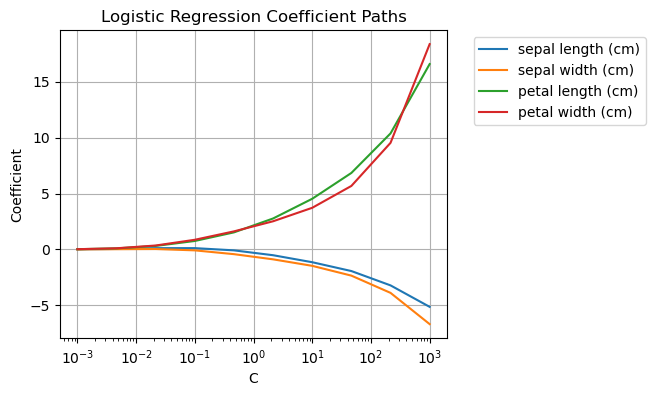

In [9]:
# Extract the coefficients
# coefs_paths_ is a dictionary with class labels as keys
coefs_paths = clf.coefs_paths_["virginica"]

# extract feature names
feature_names = df_iris_subset.iloc[:, :4].columns

# Plot the coefficient paths for one the cross-validation splits
plt.figure(figsize=(5, 4))
for i in range(coefs_paths.shape[2]):
    plt.plot(Cs, coefs_paths[0, :, i], label=f"{feature_names[i]}")


plt.xlabel("C")
plt.ylabel("Coefficient")
plt.title("Logistic Regression Coefficient Paths")
plt.xscale("log")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.grid(True)
plt.show()

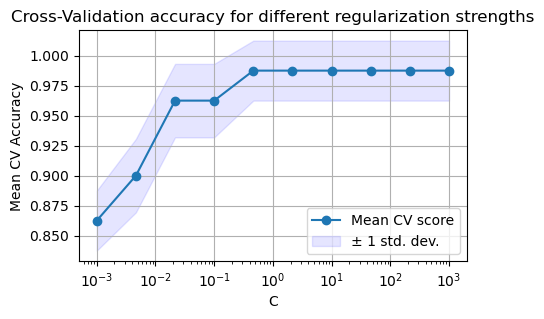

In [10]:
scores = clf.scores_["virginica"]
plt.figure(figsize=(5, 3))
plt.plot(Cs, scores.mean(axis=0), marker="o", label="Mean CV score")
plt.fill_between(
    Cs,
    scores.mean(axis=0) - scores.std(axis=0),
    scores.mean(axis=0) + scores.std(axis=0),
    alpha=0.1,
    color="b",
    label="± 1 std. dev.")
plt.xscale("log")
plt.xlabel("C")
plt.ylabel("Mean CV Accuracy")
plt.title("Cross-Validation accuracy for different regularization strengths")
plt.grid(True)
plt.legend()
plt.show()